# Feature engineering

In this notebook we cover examples of common feature engineering tasks on both numeric and categorical data. The goal isn't to be exhaustive, but provide you with enough examples that you can get the picture.

We begin with numeric features. Let's begin by reading some data.

In [1]:
import pandas as pd
import numpy as np

auto = pd.read_csv('data/auto-mpg.csv', sep = '\s+', header = None, 
                   names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 
                            'acceleration', 'model year', 'origin', 'car_name'])
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


Let's check the data types:

In [2]:
auto.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
model year        int64
origin            int64
car_name         object
dtype: object

We can see that we have quite a few numeric columns in here. However, we also need to be careful: a column like `cylinders` looks numeric, but probably should be treated as a categorical column. Why? As yourself which one of these two is more likely:

- do any kind of math with `cylinders`, such as taking the log of it, adding it to another column, or being interested in knowing the average number of cylinders?
- use cylinder as a grouping variable, such as wanting to see the average horsepower **by cylinder**?

We can probably agree that the second case is more likely. For this reason, we need convert cylinder into a categorical column. More on categorical columns in the next lesson.

In [3]:
auto['cylinders'] = auto['cylinders'].astype('category')

Let's now look at some distributions for our numeric columns.

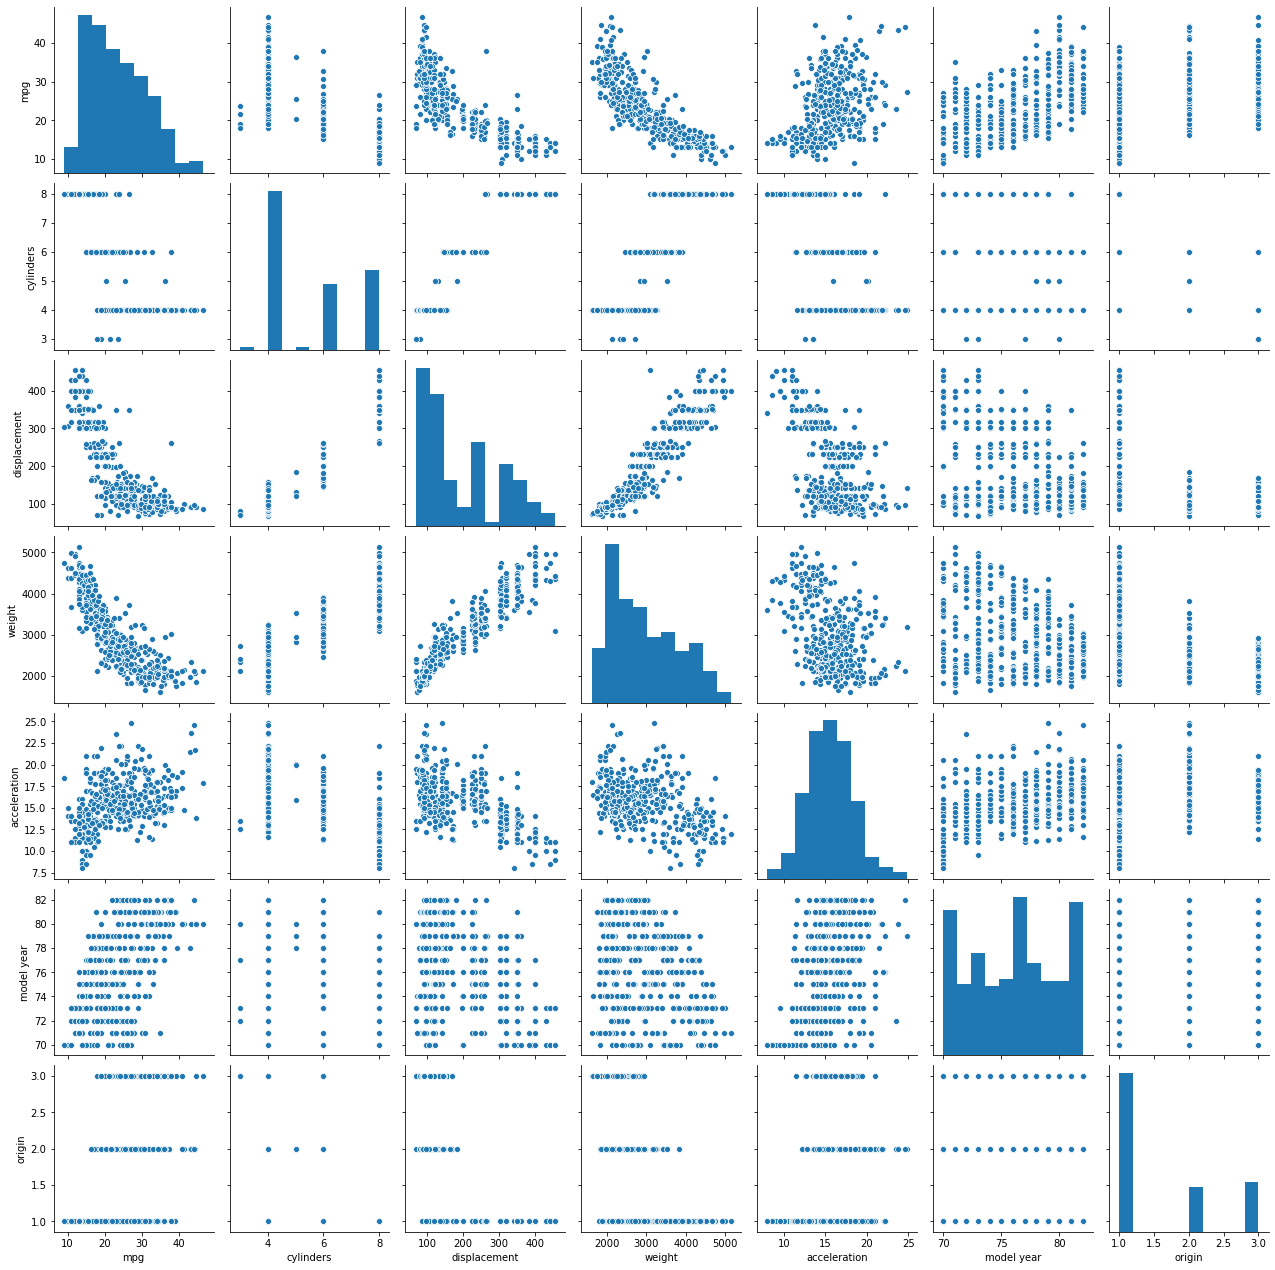

In [4]:
import seaborn as sns

sns.pairplot(auto);

None of the feature seem to have any extreme values. Let's check for missing values. To see if any columns in the data are missing, we can use the `isnull` method, followed by `any` where the `axis = 0` is used to ask if **any** of values **across columns** is null: `False` means that none is missing, and `True` means that at least one value is missing.

In [5]:
auto.isnull().any(axis = 0)

mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
model year      False
origin          False
car_name        False
dtype: bool

Even better would be to use `sum` to get the count of rows in for each column that are missing.

In [6]:
auto.isnull().sum(axis = 0)

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car_name        0
dtype: int64

Note that all of this would work only if the missing data is properly marked as null. Often when reading external data sources, other conventions are used to mark data as missing, such as using `-999` for numeric data, or the string `NA` or `?` or the empty string for categorical data. Such values by default would not be picked up by `isnull`. So we would need to first recode them (or overwrite them) with `np.nan`.

### Exercise

Let's illustrate the above point with an example, let's intentially introduce a few missing values in the data, but using characters that won't be recognized as such.

In [7]:
auto.loc[2, ['mpg', 'car_name']] = [-999, ""] # make mpg and car_name in the 3st row NA
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,-999.0,8,318.0,150.0,3436.0,11.0,70,1,
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


Check to see if `pandas` can detect the missing values.

In [8]:
auto.isnull().any(axis = 0)

mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
model year      False
origin          False
car_name        False
dtype: bool

Replace the above missing values with `np.nan` and check if the missing values now show.

In [9]:
auto.loc[2, ['mpg', 'car_name']] = [np.nan, np.nan]
# auto['mpg'] = auto['mpg'].replace({-999:np.nan})

Now show any rows in the data that have any missing values. HINT: you will need to change `axis = 1`.

In [10]:
auto[auto.isnull().any(axis=1)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car_name
2,NaN,8,318.0,150.0,3436.0,11.0,70,1,NaN


### End of exercise

Let's look at some summary statistics for `acceleration`. One quick and easy way to do that is using `describe`.

In [11]:
auto['acceleration'].describe()

count    398.000000
mean      15.568090
std        2.757689
min        8.000000
25%       13.825000
50%       15.500000
75%       17.175000
max       24.800000
Name: acceleration, dtype: float64

Looking at percentiles helps us get a feel for the distribution of the data. For example, looking at very low or very high percentiles can help us identify **outliers** or **extreme values**. We can use the `quantile` method to get any percentile we want. Here's how:

In [12]:
percentiles = [0, 0.05, 0.50, 0.95, 1]
auto.quantile(q = percentiles)

,mpg,displacement,weight,acceleration,model year,origin
0.00,9.00,68.0,1613.0,8.000,70.0,1.0
0.05,13.00,85.0,1923.5,11.285,70.0,1.0
0.50,23.00,148.5,2803.5,15.500,76.0,1.0
0.95,37.04,400.0,4464.0,20.415,82.0,3.0
1.00,46.60,455.0,5140.0,24.800,82.0,3.0


Now let's see how we can obtain these same summary statistics, but grouped by `cylinders`. There is already one way we know how to do that: we can first subset the data by `cylinders == 3` and run the summary statistic, then do the same for `cylinders == 4`, etc.

In [13]:
auto.loc[auto['cylinders'] == 3, :].quantile(q = percentiles)

,mpg,displacement,weight,acceleration,model year,origin
0.00,18.00,70.0,2124.0,12.50,72.00,3.0
0.05,18.15,70.0,2154.9,12.65,72.15,3.0
0.50,20.25,70.0,2375.0,13.50,75.00,3.0
0.95,23.37,78.5,2675.0,13.50,79.55,3.0
1.00,23.70,80.0,2720.0,13.50,80.00,3.0


But of course the above way is tedious. Instead, we can use the `groupby` method to do it all at once. For example, here's the average of each column grouped by `cylinders`.

In [14]:
auto.groupby('cylinders').mean()

,mpg,displacement,weight,acceleration,model year,origin
cylinders,,,,,,
3,20.550000,72.500000,2398.500000,13.250000,75.500000,3.000000
4,29.286765,109.796569,2308.127451,16.601471,77.073529,1.985294
5,27.366667,145.000000,3103.333333,18.633333,79.000000,2.000000
6,19.985714,218.142857,3198.226190,16.263095,75.928571,1.190476
8,14.933333,345.009709,4114.718447,12.955340,73.902913,1.000000


A slightly confusing thing happens if we use a method like `describe` or `quantile` instead of `mean`:

In [15]:
auto.groupby('cylinders').describe()

mpg                                                        \
           count       mean       std   min    25%    50%    75%   max   
cylinders                                                                
3            4.0  20.550000  2.564501  18.0  18.75  20.25  22.05  23.7   
4          204.0  29.286765  5.710156  18.0  25.00  28.25  33.00  46.6   
5            3.0  27.366667  8.228204  20.3  22.85  25.40  30.90  36.4   
6           84.0  19.985714  3.807322  15.0  18.00  19.00  21.00  38.0   
8          102.0  14.933333  2.834069   9.0  13.00  14.00  16.00  26.6   

          displacement              ... model year       origin            \
                 count        mean  ...        75%   max  count      mean   
cylinders                           ...                                     
3                  4.0   72.500000  ...      77.75  80.0    4.0  3.000000   
4                204.0  109.796569  ...      80.00  82.0  204.0  1.985294   
5                  3.0  145.000000  ...      79.50  80.0    3.0  2.000000   
6                 84.0  218.142857  ...      78.00  82.0   84.0  1.190476   
8                103.0  345.009709  ...      76.00  81.0  103.0  1.000000   

                                              
                std  min  25%  50%  75%  max  
cylinders                                     
3          0.000000  3.0  3.0  3.0  3.0  3.0  
4          0.833285  1.0  1.0  2.0  3.0  3.0  
5          0.000000  2.0  2.0  2.0  2.0  2.0  
6          0.548298  1.0  1.0  1.0  1.0  3.0  
8          0.000000  1.0  1.0  1.0  1.0  1.0  

[5 rows x 48 columns]

The problem with the above table is that there's too much information packed in it. Each value of `cylinders` has its own row, which is fine. But the columns look like they have a hierarchical structure, which makes sense because we asked for many summary statistics for each column.

So what if for example we wanted to store all the results from the above table, and then look at the results for `acceleration` only. Turns out we can do the same thing we usually do:

In [16]:
results_all = auto.groupby('cylinders').describe()
results_all['acceleration']

,count,mean,std,min,25%,50%,75%,max
cylinders,,,,,,,,
3,4.0,13.250000,0.500000,12.5,13.250,13.5,13.5,13.5
4,204.0,16.601471,2.382210,11.6,14.800,16.2,18.0,24.8
5,3.0,18.633333,2.369247,15.9,17.900,19.9,20.0,20.1
6,84.0,16.263095,2.021140,11.3,15.075,16.1,17.6,21.0
8,103.0,12.955340,2.224759,8.0,11.500,13.0,14.0,22.2


The difference is that `results_all['acceleration']` isn't just a single column, but many columns. That's because `results_all` has hierarchical columns. So if we want to drill further down to a specific column, such as `std`, we need to go one level deeper.

In [17]:
results_all['acceleration']['std']

cylinders
3    0.500000
4    2.382210
5    2.369247
6    2.021140
8    2.224759
Name: std, dtype: float64

So far it looks like hierarchical columns are not that complicated. However, things do get a little confusing when we want to cross the hierarchy the other way around. For example, let's say we want to quickly compare the standard deviations of all our columns, grouped by `cylinders`. This information is in the above table, but how do we extract it?

It turns out that to do this, we need to use the `IndexSlice` function in `pandas`. Here how it works:
- we use `loc` to say which rows and columns we want
- we use `slice(None)` to say we want everything at a given hierarchy
- if we want to filter at any level of hierarchy, we provide the index we want to filter by

In [18]:
from pandas import IndexSlice as idx
results_all.loc[: , idx[:, 'std']]

,mpg,displacement,weight,acceleration,model year,origin
,std,std,std,std,std,std
cylinders,,,,,,
3,2.564501,5.000000,247.566153,0.500000,3.696846,0.000000
4,5.710156,21.512147,347.093936,2.382210,3.753420,0.833285
5,8.228204,33.286634,374.343870,2.369247,1.000000,0.000000
6,3.807322,32.293512,332.297419,2.021140,3.251638,0.548298
8,2.834069,46.776376,448.833159,2.224759,3.021214,0.000000


By the way, the same way that we can have hierarchical columns, we can also have hierarchical rows, more specifically hierachical row indexes. Examine the result generated by the cell below. Do see the hierarchical structure of the row index?

In [19]:
auto.groupby('cylinders').quantile(q = percentiles)

TypeError: 'quantile' cannot be performed against 'object' dtypes!

Hierarchical indexes are called `MultiIndex` in `pandas`. This is a more advanced topic and we will leave it at that for now.

### Exercise

We saw how a histogram shows us counts for **evenly-sized** intervals of a numeric column. What if we wanted to see counts for any intervals we specify, evenly-sized or not? Here's an example:

Find out how many cars have `mpg` less than 18, between 18 and 25, and 25 or more?

Note that there are many ways of doing this, so to narrow it down a little do this:
- use `loc` to limit data to the above ranges
- use the `shape` method to get row counts

In [20]:
auto.loc[auto["mpg"] <= 18, :].shape[0]

123

In [21]:
auto.loc[auto["mpg"] >= 25, :].shape[0]

169

In [22]:
auto.loc[(auto.loc[:, 'mpg'] > 18) & (auto.loc[:, 'mpg'] < 25), :].shape[0]

105

Check what happens if some of your data points fall outside of any of intervals. Does this match what you would expect?

### End of exercise

There is another, much faster way to solve the exercise above: by using the `pd.cut` function and specify the cut-offs using the `bins` argument.

In [24]:
auto['mpg_cat'] = pd.cut(auto['mpg'], bins = [0, 18, 25, 100])
auto[['mpg', 'mpg_cat']].head()

,mpg,mpg_cat
0,18.0,"(0.0, 18.0]"
1,15.0,"(0.0, 18.0]"
2,NaN,NaN
3,16.0,"(0.0, 18.0]"
4,17.0,"(0.0, 18.0]"


Now we can just use `value_counts` to get our counts.

In [25]:
auto['mpg_cat'].value_counts(dropna = False)

(25.0, 100.0]    158
(0.0, 18.0]      123
(18.0, 25.0]     116
NaN                1
Name: mpg_cat, dtype: int64

### Exercise

Let's create `mpg_cat` again, but make the following changes to it: 

- Note that the choice of using 0 and 100 as the lower and upper bounds is a little arbitrary. So use `-np.Inf` and `np.Inf` instead.
- By default, cut labels the catgories based on the interval range it covers, but we can change the labels to anything we like using the `labels` argument. Rename the labels to `low`, `med` and `high`.

In [26]:
auto['mpg_cat'] = pd.cut(auto['mpg'], bins = [-np.Inf, 18, 25, np.Inf], labels=['low', 'med', 'high'])
auto[['mpg', 'mpg_cat']].head()

,mpg,mpg_cat
0,18.0,low
1,15.0,low
2,NaN,NaN
3,16.0,low
4,17.0,low


In [27]:
auto['mpg_cat'].value_counts()

high    158
low     123
med     116
Name: mpg_cat, dtype: int64

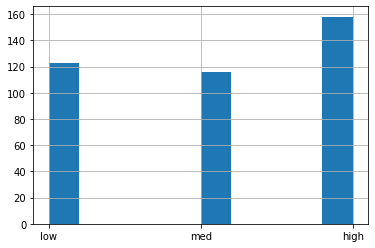

In [28]:
auto['mpg_cat'].hist()

### End of exercise

The `pd.cut` function is different from the other functions (or methods) we learned about so far. The `describe`, `mean`, `quantile`, or `value_counts` functions are **feature summarization** functions, but `pd.cut` is a **feature transformation** function, meaning that not only its input is a feature, but its output is also a feature. In the above example, the input to `pd.cut` was `mpg`, and the output was the `mpg_cat` which we appended to the data as a new column.

There are many other **feature transformation** functions. In fact, **feature engineering** consists of running these feature transformations on the data and gradually modifying existing columns and adding new features to the data, with the goal of ending up with features that are more useful to the model than the original features we started with.

### Exercise

Normalize `mpg`, `displacement`, `weight` and `acceleration`. Instead of overwriting the original columns, add the normalized features as new columns and name each column using the column name and a `_norm` suffix. You are free to choose between Z-normalization or min-max normalization.

In [81]:
def scale(col):
    mean_col = np.mean(col)
    sd_col = np.std(col)
    std = (col - mean_col) / sd_col
    return std

for c in ['mpg', 'displacement', 'weight', 'acceleration']:
    auto[c + '_norm'] = scale(auto[c])
    
auto[['mpg_norm', 'displacement_norm', 'weight_norm', 'acceleration_norm']].head()

,mpg_norm,displacement_norm,weight_norm,acceleration_norm
0,-0.707773,1.090604,0.630870,-1.295498
1,-1.091843,1.503514,0.854333,-1.477038
2,NaN,1.196232,0.550470,-1.658577
3,-0.963820,1.061796,0.546923,-1.295498
4,-0.835796,1.042591,0.565841,-1.840117


Unless your Python skills are improving by leaps and bounds, you probably normalized the features one at a time. What if we wanted to do it all at once? Write a loop to iterate over the four columns and normalize each. To make it easier, we already put the column names in a list for you.

In [83]:
num_cols = ['mpg', 'displacement', 'weight', 'acceleration']


for c in num_cols:
    auto[c + '_norm'] = scale(auto[c])
    
auto[['mpg_norm', 'displacement_norm', 'weight_norm', 'acceleration_norm']].head()

,mpg_norm,displacement_norm,weight_norm,acceleration_norm
0,-0.707773,1.090604,0.630870,-1.295498
1,-1.091843,1.503514,0.854333,-1.477038
2,NaN,1.196232,0.550470,-1.658577
3,-0.963820,1.061796,0.546923,-1.295498
4,-0.835796,1.042591,0.565841,-1.840117


There is an even better way to run our transformations all at once without writing a loop. First we have to write a function whose input is an array and whose output is an array of the same size with the values normalized. Write such a function and use the below cell to test it and make sure it worked.

In [84]:
def normalize(x):
    x_norm = scale(x) # write your function
    return x_norm

x_test = np.array([3, 5, 9, 11, 2, 0])
normalize(x_test)

array([-0.51639778,  0.        ,  1.03279556,  1.54919334, -0.77459667,
       -1.29099445])

Time to apply the function to the data. To apply the function, we use the `apply` method.
- note that we need to limit the data to only the four columns we wish to transform
- we need to use the `axis = 1` argument to let `apply` know that the transformation applies to columns (`axis = 0` would apply it to rows, which is not what we want here)

Apply the transformation to the data and check the results using `head`. Then do an additional sanity check:
- if your function is doing Z-normalization, then check the mean and standard deviation of your normalized columns to make sure they are 0 and 1 respectively
- if your function is doing min-max normalization, then check the minimum and maximum values of your normalized columns to make sure they are 0 and 1 respectively

In [87]:
norm_cols = [col + '_norm' for col in num_cols]
auto[norm_cols] = auto[num_cols].apply(normalize, axis=0)
auto[norm_cols].head()

,mpg_norm,displacement_norm,weight_norm,acceleration_norm
0,-0.707773,1.090604,0.630870,-1.295498
1,-1.091843,1.503514,0.854333,-1.477038
2,NaN,1.196232,0.550470,-1.658577
3,-0.963820,1.061796,0.546923,-1.295498
4,-0.835796,1.042591,0.565841,-1.840117


### End of exercise

Since normalization is a very common task, you shoudn't be surprised to find out that there is already a function for doing this. I hope you still found the previous exercise useful!

However, this time we have to go to the `sklearn` library to find our function. The `sklearn` library is Python's most common machine learning library and one that we will return to in future lectures. In addition to the machine learning algorithms we will learn about, `sklearn` also has functions for **pre-processing data**, which is a vague term that includes tasks such as missing-value imputation, feature engineering and so on. Let's see how we can use it to normalize our data.

In [88]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
num_cols_norm = [c + '_norm' for c in num_cols] # names of transformed columns

At first blush, this code might look a little strange, but this pattern as we will see is very common to ML-related tasks in `sklearn`:
- initialize the process by choosing the function (with arguments we wish, if any)
- run `fit` first on the data, followed by `transform` to apply the transformation

In [89]:
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(auto[num_cols])
auto[num_cols_norm] = pd.DataFrame(minmax_scaler.transform(auto[num_cols]))
auto[num_cols_norm].head()

,mpg_norm,displacement_norm,weight_norm,acceleration_norm
0,0.239362,0.617571,0.536150,0.238095
1,0.159574,0.728682,0.589736,0.208333
2,NaN,0.645995,0.516870,0.178571
3,0.186170,0.609819,0.516019,0.238095
4,0.212766,0.604651,0.520556,0.148810


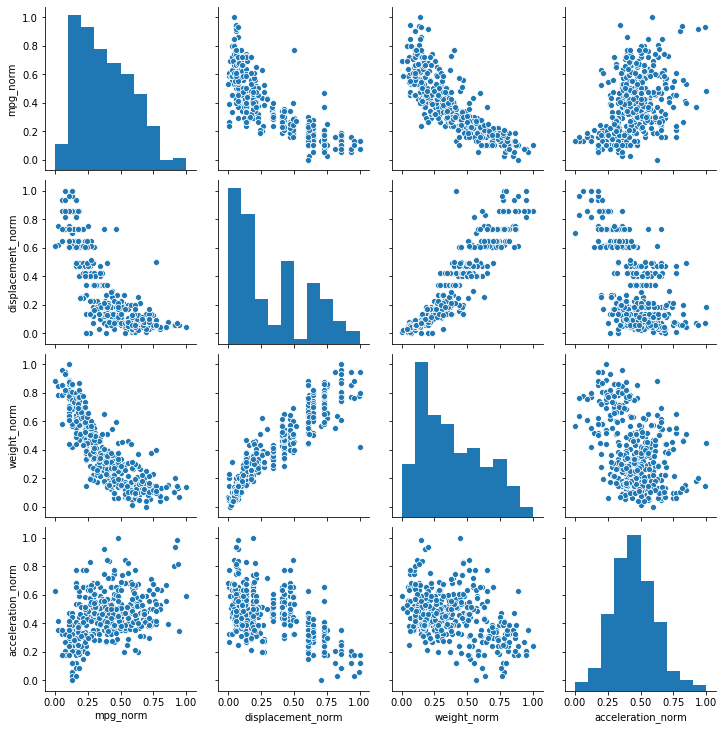

In [90]:
sns.pairplot(auto[num_cols_norm]);

Here's the same example, but using Z-normalization.

In [91]:
znorm_scaler = StandardScaler()
znorm_scaler.fit(auto[num_cols])
auto[num_cols_norm] = pd.DataFrame(znorm_scaler.transform(auto[num_cols]))
auto[num_cols_norm].head()

,mpg_norm,displacement_norm,weight_norm,acceleration_norm
0,-0.707773,1.090604,0.630870,-1.295498
1,-1.091843,1.503514,0.854333,-1.477038
2,NaN,1.196232,0.550470,-1.658577
3,-0.963820,1.061796,0.546923,-1.295498
4,-0.835796,1.042591,0.565841,-1.840117


Let's look at the scatter plot matirx for the normalized features.

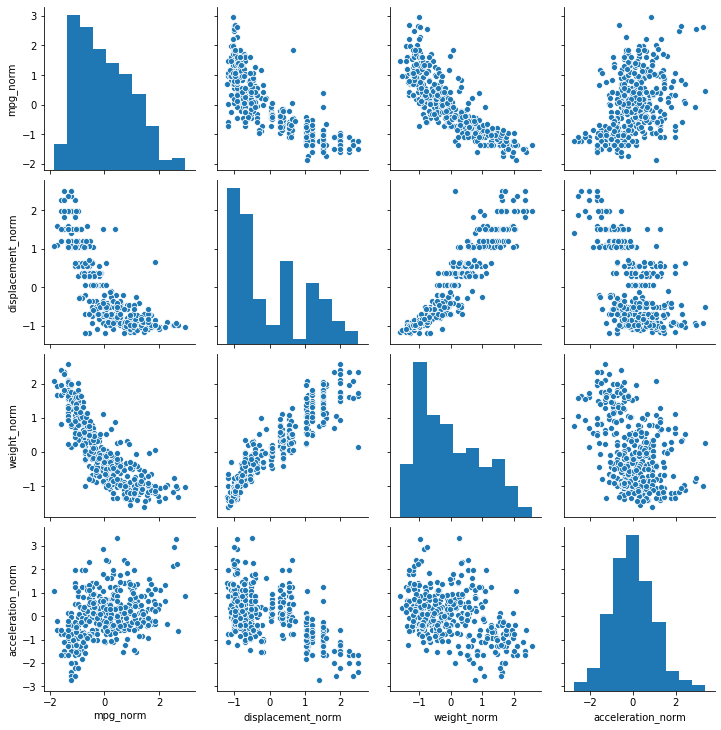

In [92]:
sns.pairplot(auto[num_cols_norm]);

In either case, it doesn't look like normalization did anything to make our scatter plot matrix looks different. Do you notice what changed? The answer is that the **scale of the data** is what changed. Just check the $x$ and $y$ axes and you'll see. Normalization is not really supposed to change the nature of the data, just put all features on the same scale.

Let's look one last time at the code for normalizing the data using `sklearn`.

In [93]:
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(auto[num_cols])
auto[num_cols_norm] = pd.DataFrame(minmax_scaler.transform(auto[num_cols]))
auto[num_cols_norm].head()

,mpg_norm,displacement_norm,weight_norm,acceleration_norm
0,0.239362,0.617571,0.536150,0.238095
1,0.159574,0.728682,0.589736,0.208333
2,NaN,0.645995,0.516870,0.178571
3,0.186170,0.609819,0.516019,0.238095
4,0.212766,0.604651,0.520556,0.148810


There's two things we need to point out about the code above:

In the third line, notice how we used `pd.DataFrame` to turn the data into a `DataFrame` object. This is because `sklearn` returns a `numpy` array instead of a `DataFrame`. As we saw earlier, the distinction is most of the time unimportant since a `DataFrame` is just a sort of wrapper for a `numpy` array, but if we want to use `DataFrame` methods like `head` to examine the results, we need to do our own conversion.

You might be curious why we use `fit` followed by `transform`. What exactly happens when we run `fit`? Why should those two not be steps not be a single step? The answer to that will become obvious later in the context of machine learning, but here's a short answer using `MinMaxScaler` as our example:
  - When we run `fit` we find the min and max for the columns and rememeber it.
  - When we run `transform` we apply the transformation using the min and max we found when we ran `fit`.

This means that we can learn the min and max once, and then apply the **same** transformation (with the same min and max) not just to the original data, but any future data. In machine learning, this has important consequences, but that's the topic of a future lecture.

It's time now to shift focus away from numeric features and talk about feature engineering for categorical features. We will use another dataset for this.

In [29]:
tennis = pd.read_csv("data/tennis.csv")
tennis.head()

,outlook,temp,humidity,windy,play
0,sunny,hot,high,strong,no
1,sunny,hot,high,weak,no
2,overcast,hot,high,weak,yes
3,rain,mild,high,weak,yes
4,rain,cool,normal,weak,yes


As we can see, the data only contains categorical features. Let's see what the categories are for each feature.

### Exercise

Write a loop to obtain counts of unique values for each column in the data. We can use the `value_counts` method to get counts for a column.

In [30]:
for c in tennis.columns:
    print(tennis[c].value_counts())

sunny       5
rain        5
overcast    4
Name: outlook, dtype: int64
mild    6
hot     4
cool    4
Name: temp, dtype: int64
high      7
normal    7
Name: humidity, dtype: int64
weak      8
strong    6
Name: windy, dtype: int64
yes    9
no     5
Name: play, dtype: int64


### End of exercise

Let's see what happens if we one-hot-encode the above data. Just like normalization, one-hot-encoding is a common pre-processing task and we can turn to the `sklearn` library to do the hard part for us. And once again, we will see the pattern of using `fit` followed by `transform`.

In [31]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(sparse = False) # initialize one-hot-encoder
onehot.fit(tennis)
col_names = onehot.get_feature_names(tennis.columns) # this allows us to properly name columns
tennis_onehot =  pd.DataFrame(onehot.transform(tennis), columns = col_names)
tennis_onehot.head()

,outlook_overcast,outlook_rain,outlook_sunny,temp_cool,temp_hot,temp_mild,humidity_high,humidity_normal,windy_strong,windy_weak,play_no,play_yes
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


So we can see that one-hot encoding created a **binary feature** for **each category of each categorical column** in the data. These binary features are also sometimes called **dummy variables**. Why do we do this? The reason we do this is that most machine learning algorithms do not work **directly** with categorical data, so we need to encode the categorical data which turns it into numeric data. One-hot encoding is just one type of encoding, but it is the most common one.

One last note about the `sklearn` pre-processing transformations we learned about in this notebook: If you look at examples online, you may notice that instead of calling `fit` and `transform` separately, you can call `fit_transform` which combines the two steps into one. This may seem reasonable and saves you one extra line of code, but we discourage it. The following exercise will illustrate why, but the main reason will become clear when we talk about machine learning.

### Exercise

Let's return to the tennis data, and fit a one-hot encoder on it.

In [32]:
tennis = pd.read_csv("data/tennis.csv")
onehot = OneHotEncoder(sparse = False, handle_unknown = 'ignore') # initialize one-hot-encoder
onehot.fit(tennis)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=False)

We now introduce a change: we will add an additional category to `outlook` called `amazing`. The important point here is that we introduce this additional category **after** we ran `fit` on the one-hot encoder above.

In [33]:
tennis.loc[2, "outlook"] = "amazing" # introduce a category unseen when we ran fit

Now let's see what happens if we try to run `transform` on the data to one-hot encode the features. If you run the code below you'll notice that we get an error. What is the error for?

In [34]:
col_names = onehot.get_feature_names(tennis.columns)
tennis_onehot =  pd.DataFrame(onehot.transform(tennis), columns = col_names)
tennis_onehot.head()

,outlook_overcast,outlook_rain,outlook_sunny,temp_cool,temp_hot,temp_mild,humidity_high,humidity_normal,windy_strong,windy_weak,play_no,play_yes
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


Is it a good thing that we got an error? The answer is it depends: 

- If we are okay with letting new categories slip through, we can return to where we initiated `OneHotEncoder` and change the `handle_unknown = 'ignore'` (default value is `'error'`). Make this change and rerun the code. What is the one-hot encoded value for `outlook` at the row that we changed?
- If you want to make sure that we preserve **data integrity** so that the data we call `transform` on matches the schema of the data we ran `fit` on, then we want errors like this to stop us in our tracks so we have a change to see why the data changed.

### End of exercise

Now that we covered common transformations for both numeric and categorical features, let's look at an example of a special transformation very common in the retail industry: RFM or recency-frequency-monetary transformation.

Prior to running the following code, make sure you upgrade `pandas` to version `1.0.1` by running `pip install pandas==1.0.1`. You can check the current version of pandas by running the next cell.

In [38]:
import pandas as pd
pd.__version__

'1.0.2'

Let's read our data.

In [39]:
col_names = ['user_id', 'gender', 'address', 'store_id', 'trans_id', 'timestamp', 'item_id', 'quantity', 'dollar']
churn = pd.read_csv("data/retail-churn.csv", sep = ",", skiprows = 1, names = col_names)
churn.head()

,user_id,gender,address,store_id,trans_id,timestamp,item_id,quantity,dollar
0,101981,F,E,2860,818463,11/1/2000 0:00,4.710000e+12,1,37
1,101981,F,E,2861,818464,11/1/2000 0:00,4.710000e+12,1,17
2,101981,F,E,2862,818465,11/1/2000 0:00,4.710000e+12,1,23
3,101981,F,E,2863,818466,11/1/2000 0:00,4.710000e+12,1,41
4,101981,F,E,2864,818467,11/1/2000 0:00,4.710000e+12,8,288


The first thing we need to do is convert the datetime column to `datetime`.

In [40]:
churn['timestamp'] = pd.to_datetime(churn['timestamp'], format = '%m/%d/%Y %H:%M')
churn['date'] = churn['timestamp'].dt.date

Notice that we run into a problem with our data: the **granularity** of the data is not daily spend, but rather individual transactions. You can see that because the same user has multiple transactions with the same timestamp. This means that before we can do feature engineering, we need to **aggregate** the data to daily data so that `user_id` and `date` are unique for each row. In the process, we also get rid of all the columns we don't need.

In [41]:
churn_agg = churn.groupby(['user_id', 'date']).agg({'dollar': 'sum', 'quantity': 'sum'})
churn_agg = churn_agg.reset_index()

In [42]:
# churn_agg['date'] = churn_agg['date'].astype('datetime64')
churn_agg['date'] = pd.to_datetime(churn_agg['date'])
churn_agg.dtypes

user_id              int64
date        datetime64[ns]
dollar               int64
quantity             int64
dtype: object

With the aggregated data, we can now obtain recency, frequency and monetary features:
- In `pandas` recency is a kind of **difference** feature, because it's based on calculating the difference between the current date and a previous date (called a **lag**). We can use the `diff` function to get recency.
- Frequency and monetary features are called **rolling** features, because it is a type of cumulative sum but over a moving window. We can use the `rolling` function to get frequency and monetary, where `window = '7D'` means we're using a 7-day moving window, and `on = 'date'` means that the moving window moves over `date`.

In [43]:
roll_sum = churn_agg.groupby('user_id').rolling(window = '7D', on = 'date')['dollar'].sum()
roll_cnt = churn_agg.groupby('user_id').rolling(window = '7D', on = 'date')['quantity'].sum()
roll_min = churn_agg.groupby('user_id')['date'].diff(periods = 1)

We now combine all three features into a single `DataFrame` which we call `churn_roll`. For recency, we can use `fillna` to replace missing values with a large value like 100 days or whatever makes business sense.

In [44]:
churn_roll = pd.concat([roll_sum, roll_cnt], axis = 1)
churn_roll.columns = ['dollar_roll_sum_7D', 'quantity_roll_sum_7D']
churn_roll = churn_roll.reset_index()
churn_roll['last_visit_ndays'] = roll_min.fillna(pd.Timedelta('100 days'))

To see if things worked, let's first comibne the aggregated data with the data with the new features. We can use the `merge` method to do this. We can check the recency (named `last_visit_ndays`), frequency (named `quantity_roll_sum_7D`) and monetary (named `dollar_roll_sum_7D`) columns to make sure the calculations look correct.

In [45]:
churn_all = churn_agg.merge(churn_roll, how = "inner", on = ['user_id', 'date'], 
                            validate = 'one_to_one')
churn_all.head()

,user_id,date,dollar,quantity,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,1113,2000-11-12,420,5,420.0,5.0,100 days
1,1113,2000-11-26,558,3,558.0,3.0,14 days
2,1113,2000-11-27,624,6,1182.0,9.0,1 days
3,1113,2001-01-06,628,9,628.0,9.0,40 days
4,1250,2001-02-04,734,5,734.0,5.0,100 days


One take-away from the above example is that feature engineering can be a complicated topic, and relies to some extent on creativity and domain knowledge, as we saw with time series data and RFM. For this reason, some modern machine learning libraries are working on what is called **automated feature engineering** to see if algorithms can automatically figure out a set of good features to use by the machine learning model.